<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/knn_create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN: Create Model
## In this notebook we will create a ensemble of KNN prediction models using the sample derived from the [KNN: Sample Design notebook](https://github.com/jshogland/SpatialModelingTutorials/blob/23955824e1fd8258776663a8204af23be9a8f727/Notebooks/knn_sample_design.ipynb)
### Objectives
- Learn about KNN
- Learn how to build an ensemble
- Apply the model to estimate CF/Acre and standard error

### Datasets [from knn_sample_desing.ipynb](https://github.com/jshogland/SpatialModelingTutorials/blob/23955824e1fd8258776663a8204af23be9a8f727/Notebooks/knn_sample_design.ipynb)
- Landsat 8 imagery(ls8.tif)
- Cubic Feet imagery (cf1.tif)
- Sample dataset (sb_sample.shp.zip): columns [ls8_1 - ls8_7 and cf]; n=150;
  - ls8 -> spectral reflectance for (blue,green,red,nir,mid_ir1,mid_ir2)
  - cf -> cubic feet of timber


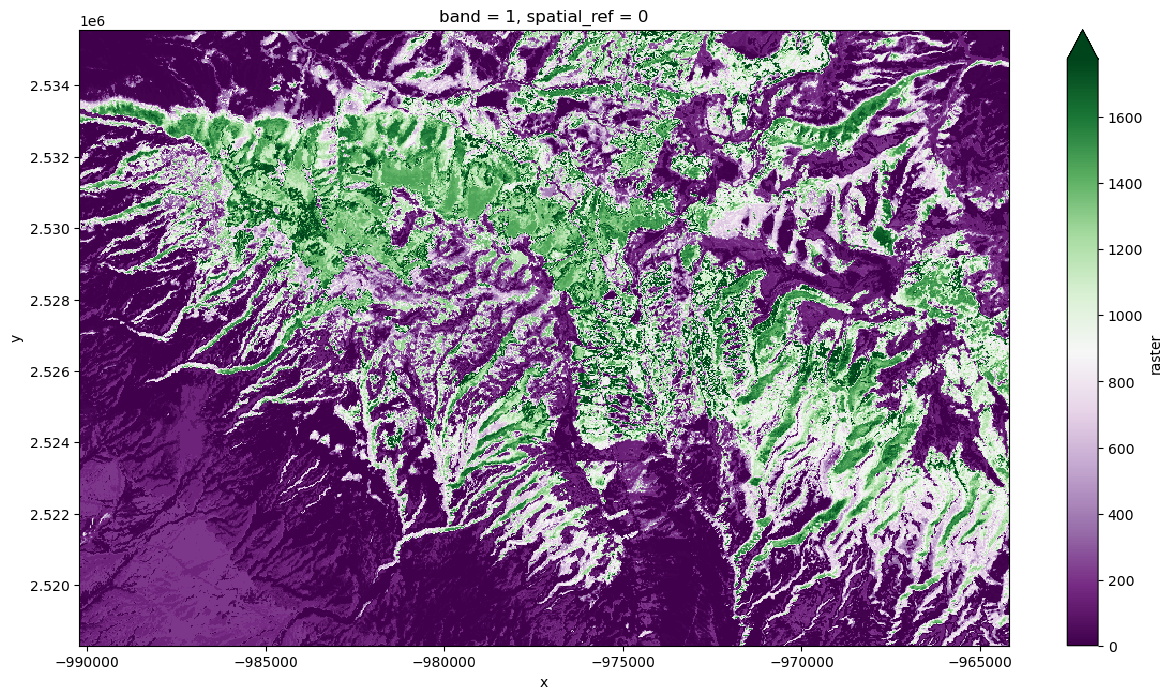

## Install packages

In [ ]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools

### Steps
1. Explore the sample
2. Create a EKNN model
3. Use the EKNN to estimate CF/Acre
4. Evaluate the model

by John Hogland 3/26/2024

## Import packages

In [ ]:
#get packages
from raster_tools import Raster,general
import geopandas as gpd, pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline

## Step 1: Explore the sample
In this step we will read in the sample data and create a scatter plot matrix of the relationship among all variables. If you have not already processed the steps in the [KNN Sample Design notebook]('knn_sample_design.ipynb'), then please work through that notebook and save all outputs from that exercise before proceeding.

In [ ]:
# read in the data
gdf=gpd.read_file('sb_sample.shp.zip')

# get the response and predictor variables
pred=gdf.columns[:-2]

# create a scatter plot matrix of all variables
pd.plotting.scatter_matrix(gdf,figsize=(15,15))

## Step 2: Create EKNN
In this step we will transform our predictor variables into normalized independent components and then use those components to create an ensemble of KNN regression models (EKNN) that can be used to estimate mean cubic feet of lumber and error per acre.  

In [ ]:
# Create a scale function that centers and scales values based on means and standard deviation (Standard Scaler)
_scaler=StandardScaler()

# Create a PCA function to perform a PCA on scaled variables (independent components)
_pca=PCA()

# Create a base KNN regression function that can be used to estimate cf/acre
_knn=KNeighborsRegressor(n_neighbors=5) #note we are averaging five neighbors

# Separate data into y (cubic feet/acre) and x (landsat predictor variables values)
y=gdf['cf'].values
X=gdf[pred].values

# Create a pipeline for scaler and PCA component and transform values
pipe = Pipeline(steps=[("scaler", _scaler), ("pca", _pca)]).fit(X)
X2=pipe.transform(X)

# Create EKNN using a Bagging Regressor
eknn=BaggingRegressor(estimator=_knn,n_estimators=50, oob_score=True).fit(X2,y)

# Create EKNN stander error estimate from EKNN
elst=[]
for e in eknn.estimators_:
    elst.append(e.predict(X2))

pdf=pd.DataFrame(elst)
p=pdf.mean(axis=0)
ste=pdf.std(axis=0)



## Evaluate the model

In [ ]:
#create a data frame of transformed values
clmns=[]
for c in range(7):
    clmns.append('comp'+str(c))

tdf=pd.DataFrame(X2,columns=clmns)
tdf['cf']=y

### Look at the transformed variables

In [ ]:
#look at scatter plot matrix of predictor variables
pd.plotting.scatter_matrix(tdf,figsize=(15,15))

### Look at the model fit

In [ ]:
# Look at the oob
print('R squared = ',eknn.oob_score_)


# Calculate the RMSE and print
gdf['pred']=p
gdf['ste']=ste

print('RMSE = ',np.sqrt(((gdf['pred']-gdf['cf'])**2).mean()))

# Plot observed vs predicted
ax=gdf.plot.scatter(x='pred',y='cf',xlim=(0,5000),ylim=(0,5000))

# Create one to one line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# Plot line on scatter plot
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

### Look at distribution of standard error

In [ ]:
# Plot ste vs predicted
ax=gdf.plot.scatter(x='cf',y='ste',)

## Step 3: Use EKNN to create raster surfaces of mean CF/Acre and standard error of the mean CF/Acre.
### Estimate mean CF/Acre

In [ ]:
# Read in landsat raster
pred_rs=Raster('ls8.tif')
# Transform landsat raster to components
pipe_a=general.ModelPredictAdaptor(pipe,'transform')
pred_tr=pred_rs.model_predict(pipe_a,X2.shape[1]).eval()
# Estimate mean CF
mcf=pred_tr.model_predict(eknn).eval()

### Estimate standard error of CF/Acre

In [ ]:
# create a new function to estimate standard error
def ste(X):
    rslst=[]
    for e in eknn.estimators_:
        elst.append(e.predict(X))

    pdf=pd.DataFrame(elst)
    return pdf.std(axis=0)

# add the function to EKNN
eknn.ste=ste

# use the adapter to convert the new function into a Raster function
eknn_ste=general.ModelPredictAdaptor(eknn,'ste')

# Estimate standard error
stecf=pred_tr.model_predict(eknn_ste).eval()


### Plot mean CF/Acre

In [ ]:
mcf.plot(figsize=(15,8),cmap='PRGn',robust=True)

### Plot Standard Error

In [ ]:
stecf.plot(figsize=(15,8),cmap='Reds',robust=True)

## Evaluate the Raster estimates
Look at the difference between observed and predicted values and determine RMSE

In [ ]:
# Read in CF raster
cf_rs=Raster('cf1.tif')

# Reproject and snap to mcf raster
cf_rs=Raster(cf_rs.xdata.rio.reproject_match(mcf.xdata)).set_null_value(-99)

# Set null values to zero to match model assumption
cf_rs=cf_rs.where(~cf_rs.to_null_mask(),0)

# Subtract raster values
dif=cf_rs-mcf

#Calculate RMSE
rmse=np.sqrt((dif**2).mean()).compute()

#Print RMSE and the difference surface
print("RMSE = ",rmse)
dif.plot(figsize=(15,8),cmap='coolwarm',robust=True)

### Determine where mean falls with  95% CL

In [ ]:
ch=(np.abs(dif)>(1.96*stecf))
ch.plot(figsize=(15,8))

## Compare population estimate to true value
### Using the sample

In [ ]:
import scipy

n=y.shape[0]
m=y.mean()
se=y.std()/np.sqrt(n)
tvl=scipy.stats.t.ppf(0.975,n-1)
t_p=cf_rs.mean().compute()

print('Sample mean =',m)
print('Sample standard error =',se)
print('n =',n)
print('95% CL =',m-tvl*se,m+tvl*se)
print('True populaton mean =',t_p)


### Using the EKNN

In [ ]:
# Calculate mean estimate for each KNN within the EKNN and store in a list
m_lst=[]
for k in eknn.estimators_:
  m_lst.append(pred_tr.model_predict(k).mean().compute())

In [ ]:
# Calculate estimates (mean and se) and graph distribution of ensemble
m2=np.mean(m_lst)
se2=np.std(m_lst)
n2=len(m_lst)

print('EKNN mean =',m2)
print('EKNN standard error =',se2)
print('n =', n2)
print('95% CL =',np.percentile(m_lst,[2.75,97.5]))
print('True populaton mean =',t_p)

# plot distribution of means for eknn
p=pd.DataFrame(m_lst,columns=['est']).hist()

In [ ]:
print('Population estimate (cf/acre)= ',mcf.mean().compute())
print('True population value (cf/acre)= ', cf_rs.mean().compute())